# Structural Estimation

Natasha Watkins

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Question 1

Part a)

In [78]:
claims = pd.read_csv('clms.txt', header=None, names=['claims'])
claims.head()

,claims
0,361.65
1,123.04
2,541.77
3,862.90
4,55.60


In [79]:
claims.agg(['mean', 'median', 'max', 'min', 'std'])

,claims
mean,720.277975
median,172.210000
max,227967.250000
min,0.010000
std,3972.850824


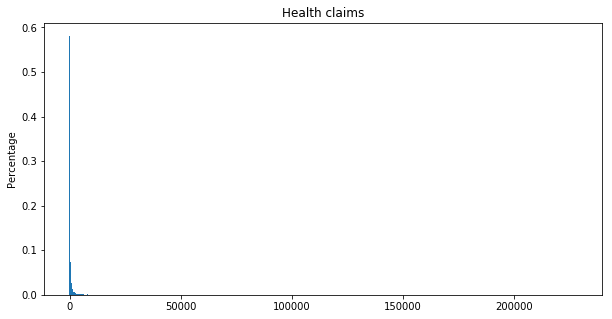

In [173]:
hist, bins = np.histogram(claims.dropna(), bins=1000)
hist_density = hist / hist.sum()
plt.figure(figsize=(10, 5))
plt.bar(np.linspace(bins.min(), bins.max(), len(hist_density)), hist_density, width=bins[1])
plt.title('Health claims')
plt.ylabel('Percentage')
plt.show()

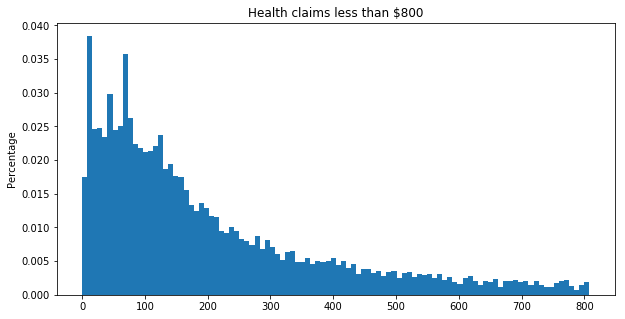

In [175]:
hist_new, bins_new = np.histogram(claims[claims <= 800].dropna(), bins=100)
hist_new = hist_new / hist.sum()
plt.figure(figsize=(10, 5))
plt.bar(np.linspace(bins_new.min(), bins_new.max(), len(hist_new)), 
        hist_new, width=bins_new[1]+0.1, align='edge')
plt.title('Health claims less than $800')
plt.ylabel('Percentage')
plt.show()

The second histogram is easier to interpret as it excludes outliers.

Part b)

In [177]:
# Initial guesses
β_0 = claims.var() / claims.mean()
α_0 = claims.mean() / β_0
X = claims.values

In [178]:
from scipy.special import gamma
from scipy.optimize import minimize

# Log likelihood of gamma(α, β) distribution
def logL_gamma(params, X):
    α, β = params
    T = len(X)
    logL = -T * α * np.log(β) + (α - 1) * np.sum(np.log(X)) - \
           (1 / β) * np.sum(X) - T * gamma(α)
    return -logL  # Return negative log-likelihood

In [179]:
MLE_gamma = minimize(logL_gamma, [α_0, β_0], 
                     args=X, method='Nelder-Mead')

α_hat, β_hat = MLE_gamma.x

# Function to plot estimated gamma(α, β) distribution
g = lambda x, α, β: (β**(-α) * x**(α - 1) * np.exp(-x / β)) / gamma(α)

print(f'α = {α_hat:.3f}')
print(f'β = {β_hat:.3f}')
print(f'logL = {-MLE_gamma.fun:.3f}')

α = 0.671
β = 1072.790
logL = -89397.302


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


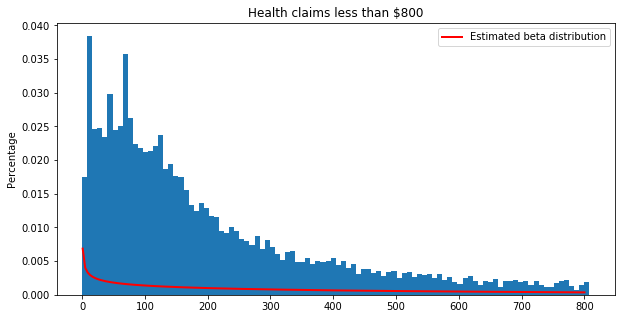

In [180]:
plt.figure(figsize=(10, 5))
plt.bar(np.linspace(bins_new.min(), bins_new.max(), len(hist_new)), 
        hist_new, width=bins_new[1]+0.1, align='edge')

x_grid = np.linspace(1, 800, 200)
plt.plot(x_grid, g(x_grid, α_hat, β_hat), 
         c='r', lw=2, label='Estimated beta distribution')

plt.legend()
plt.title('Health claims less than $800')
plt.ylabel('Percentage')
plt.show()

Part c)

In [181]:
# Log likelihood of generalized gamma(α, β, m) distribution
def logL_gamma_generalized(params, X):
    α, β, m = params
    T = len(X)
    logL = T * np.log(m) - T * α * np.log(β) + (α - 1) * np.sum(np.log(X)) - \
            np.sum((X / β)**m) - T * gamma(α / m)
    return -logL  # Return negative log-likelihood

In [182]:
MLE_gamma_ga = minimize(logL_gamma_generalized, [α_0, β_0, 1], 
                        args=X, method='Nelder-Mead')

α_hat_ga, β_hat_ga, m_hat_ga = MLE_gamma_ga.x
print(f'α = {α_hat_ga:.3f}')
print(f'β = {β_hat_ga:.3f}')
print(f'm = {m_hat_ga:.3f}')
print(f'logL = {-MLE_gamma_ga.fun:.3f}')

α = 0.922
β = 55.696
m = 0.435
logL = -86221.785


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


In [183]:
# Function to plot estimated generalized gamma distribution
ga = lambda α, β, m, x: (m / (β**α) * x**(α - 1) * np.exp(-(x / β)**m)) / gamma(α / m)

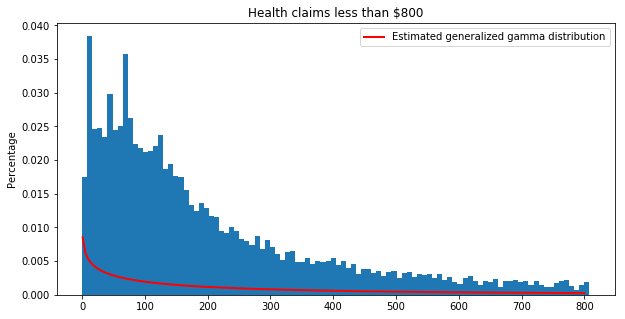

In [184]:
plt.figure(figsize=(10, 5))
plt.bar(np.linspace(bins_new.min(), bins_new.max(), len(hist_new)), 
        hist_new, width=bins_new[1]+0.1, align='edge')

plt.plot(x_grid, ga(α_hat_ga, β_hat_ga, m_hat_ga, x_grid), 
         c='r', lw=2, label='Estimated generalized gamma distribution')

plt.legend()
plt.title('Health claims less than $800')
plt.ylabel('Percentage')
plt.show()

Part d)

In [185]:
from scipy.special import beta


# Log likelihood of GB2 distribution
def logL_gb2(params, X):
    a, b, p, q = params
    T = len(X)
    logL = T * np.log(np.abs(a)) + (a * p - 1) * np.sum(np.log(X)) - T * a * p * np.log(b) - \
           T * np.log(beta(p, q)) - (p + q) * np.sum(np.log(1 + (X / b)**a))
    return -logL

In [186]:
MLE_gb2 = minimize(logL_gb2, [α_hat_ga, β_hat_ga, m_hat_ga, 200], 
                        args=X, method='L-BFGS-B')

b2 = lambda x, a, b, p, q: (np.abs(a) * x**(a * p - 1)) / (b**(a * p) * beta(p, q) * (1 + (x / b)**a)**(p + q))

In [187]:
a_hat, b_hat, p_hat, q_hat = MLE_gb2.x
print(f'a = {a_hat:.3f}')
print(f'b = {b_hat:.3f}')
print(f'p = {p_hat:.3f}')
print(f'q = {q_hat:.3f}')
print(f'logL = {-MLE_gb2.fun:.3f}')

a = -0.077
b = 3.063
p = 131.149
q = 179.471
logL = -74849.367


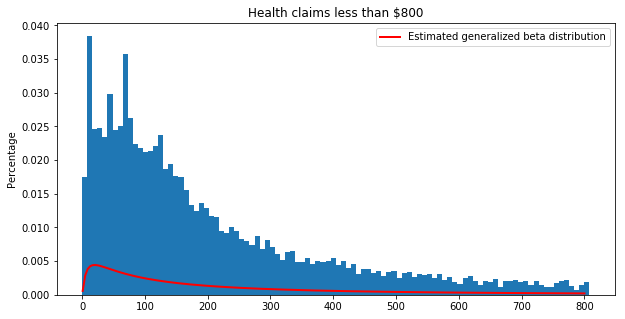

In [188]:
plt.figure(figsize=(10, 5))
plt.bar(np.linspace(bins_new.min(), bins_new.max(), len(hist_new)), 
        hist_new, width=bins_new[1]+0.1, align='edge')

plt.plot(x_grid, b2(x_grid, a_hat, b_hat, p_hat, q_hat), 
         c='r', lw=2, label='Estimated generalized beta distribution')

plt.legend()
plt.title('Health claims less than $800')
plt.ylabel('Percentage')
plt.show()

Part e)

Likelihood ratio test of model b)

In [189]:
from scipy.stats import chi2

lr1 = 2 * (MLE_gamma.fun - MLE_gb2.fun)
1 - chi2.cdf(lr1, 4)

0.0

Likelihood ratio test of model c)

In [190]:
lr2 = 2 * (MLE_gamma_ga.fun - MLE_gb2.fun)
1 - chi2.cdf(lr2, 4)

0.0

Part f)

In [191]:
from scipy.integrate import quad

quad(b2, 1000, np.inf, args=(a_hat, b_hat, p_hat, q_hat))[0]

0.13089551962909102

On average, 13% of claims are over $1000 (using the generalized beta distribution).

In [192]:
quad(g, 1000, np.inf, args=(α_hat, β_hat))[0]

0.24621473849448997

On average, 25% of claims are over $1000 (using the gamma distribution).

## Exercise 2

Part a)

In [259]:
macro = pd.read_csv('MacroSeries.txt', header=None,
                    names=['c', 'k', 'w', 'r', 'y'])

β = 0.99

In [264]:
def logL_fixed(params, w, k):
    
    α, μ, ρ, σ = params  # Unpack parameters
    
    z = np.log(w / ((1 - α) * k**α))
    
    T = z.size
    ɛ = z[1:] - ((1 - ρ) * μ  + ρ * z[:-1])  # calculate z - z_hat
    
    # Return the negative of the log-likelihood
    return (T - 1) / 2 * np.log(2 * np.pi * σ**2) + 1/(2 * σ**2) * np.sum(ɛ**2)

In [276]:
w = macro.w.values
k = macro.k.values

macro_MLE = minimize(logL_fixed, np.ones(4), args=(w, k), method='L-BFGS-B', 
                     bounds=((1e-3, 0.99), (None, None), (-0.99, 0.99), (1e-3, None)))
α_hat, μ_hat, ρ_hat, σ_hat = macro_MLE.x
print(f'α = {α_hat:.3f}')
print(f'μ = {μ_hat:.3f}')
print(f'ρ = {ρ_hat:.3f}')
print(f'σ = {σ_hat:.3f}')
print(f'logL = {macro_MLE.fun:.3f}')

α = 0.553
μ = 8.107
ρ = 0.825
σ = 0.093
logL = -94.402


Part b)

In [266]:
r = macro.r.values

def logL_fixed2(params, r, k):
    
    α, μ, ρ, σ = params  # Unpack parameters
    
    z = np.log(r / (α * k**(α - 1)))
    
    T = z.size
    ɛ = z[1:] - ((1 - ρ) * μ  + ρ * z[:-1])  # calculate z - z_hat
    
    # Return the negative of the log-likelihood
    return (T - 1) / 2 * np.log(2 * np.pi * σ**2) + 1/(2 * σ**2) * np.sum(ɛ**2)

In [277]:
macro_MLE2 = minimize(logL_fixed2, 1.5 * np.ones(4), args=(r, k), method='L-BFGS-B', 
                     bounds=((1e-3, 0.99), (1e-3, None), (-0.99, 0.99), (1e-3, 1e3)))
α_hat, μ_hat, ρ_hat, σ_hat = macro_MLE2.x
print(f'α = {α_hat:.3f}')
print(f'μ = {μ_hat:.3f}')
print(f'ρ = {ρ_hat:.3f}')
print(f'σ = {σ_hat:.3f}')
print(f'logL = {macro_MLE2.fun:.3f}')

α = 0.553
μ = 7.570
ρ = 0.825
σ = 0.093
logL = -94.402


Part c)

In [294]:
from scipy.stats import norm

k = 7_500_000
r = 1
z_prime = np.log(r / (α * k**(α - 1)))
z = 10

1 - norm(loc=(ρ_hat * z + (1 - ρ_hat) * μ_hat), scale=σ_hat).cdf(z_prime)

1.0

The probability that the interest rate is greater than 1 is close to 1